In [1]:
using PyPlot
using JuMP, Ipopt
using Random
using Distributions

Random.seed!(3);

In [2]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

include("../src/stochastic_emissions.jl");

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");
rcParams["lines.linestyle"] = "-";


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded

Response to variability in baseline emissions
Solve_Succeeded
Solve_Succeeded
NPV: 72.73930979377873 - 68.34122192335167 = 4.398087870427062
T = 2.1209726159911937 to 2.0000000011465224
Solve_Succeeded
Solve_Succeeded
NPV: 64.55971782809826 - 74.49993395383378 = -9.940216125735517
T = 1.849068036359579 to 2.0000000009849455

Response to higher geoengineering costs
Solve_Succeeded
Solve_Succeeded
NPV: 74.11119819299346 - 76.61581160441534 = -2.504613411421886
T = 2.0000000007034706 to 2.0000000008056324
Cost overuns: 1.0126481529284619
Solve_Succeeded
Solve_Succeeded
NPV: 81.73492657503665

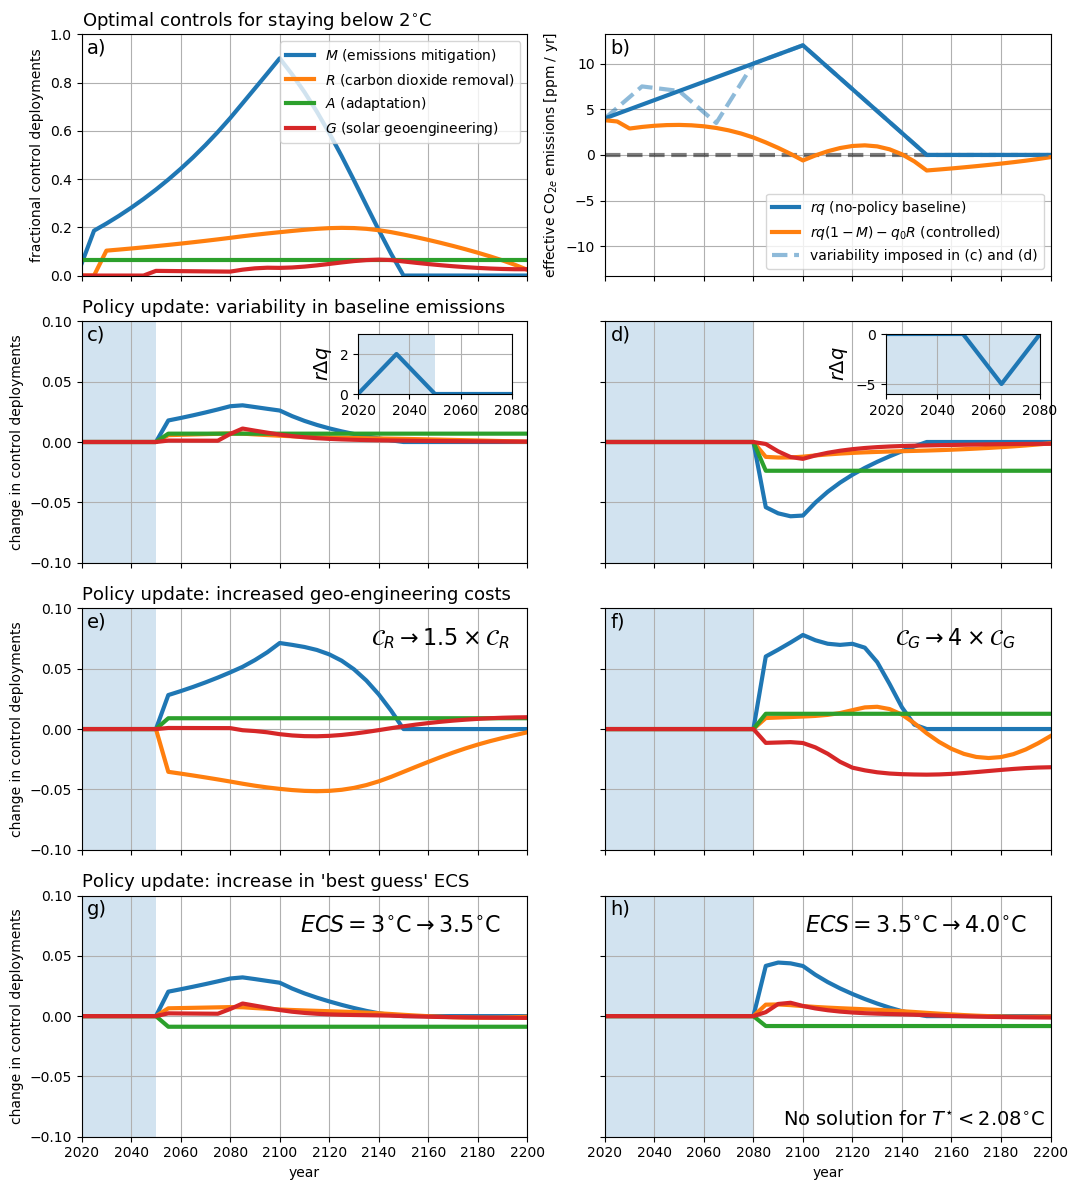


Solve_Succeeded
NPV: 73.56348990711362 - 73.50974710129663 = 0.05374280581699509
T = 2.090433811302742 to 2.0750000009068907


In [3]:
fig = figure(figsize=(11,12))

ensemble = Dict()
Δt = 30.
δq = 5.

# Random.seed!(3);
# d = Normal(0., δq)
# Δq_samples = rand(d, 2)
Δq_samples = [2., -5.]/0.4

model = ClimateModel();
optimize_controls!(model);
ensemble[string(Int64(model.present_year))] = deep_copy(model);

fig.add_subplot(4,length(Δq_samples),1)
plot_controls(model)
legend(loc="upper right")
xlabel("")
locs, labels = xticks()
xticks(locs, labels=[])
title("")
title(L"Optimal controls for staying below $2^{\circ}$C", loc="left", fontsize=13)

fig.add_subplot(4,length(Δq_samples),2)
plot_emissions(model)
xlabel("")
locs, labels = xticks()
xticks(locs, labels=[])
title("")

control_dict = Dict()
model_dict = Dict()


print("\nResponse to variability in baseline emissions\n")
previous_year = deepcopy(model.present_year)
for (n, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deep_copy(model)
    control_dict[n] = deep_copy(model)
    step_forward!(control, Δt)
    mcontrol = optimize_controls!(control);
    add_emissions_bump!(control, Δt, Δq, present_year = control.present_year - Δt)
    ensemble[control_name] = control
    
    # optimize after adding emissions
    add_emissions_bump!(model, Δt, Δq)
    step_forward!(model, Δt)
    
    NPV_old = deepcopy(discounted_total_control_cost(model))
    maxT_old = deepcopy(maximum(δT_adapt(model)))
    
    m = optimize_controls!(model);
    model_dict[n] = deep_copy(model)

    NPV_revised = discounted_total_control_cost(model)
    maxT_revised = maximum(δT_adapt(model))
    NPV_diff = NPV_revised - NPV_old
    print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
    print("T = $maxT_old to $maxT_revised\n")

    # Plotting
    fig.add_subplot(4, length(Δq_samples), length(Δq_samples)+n)
    fill_between([2020, model.present_year], [-0.1, -0.1], [0.1, 0.1], facecolor="C0", alpha=0.2)
    plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
    plot(model.domain, model.controls.remove .- control.controls.remove)
    plot(model.domain, model.controls.adapt .- control.controls.adapt)
    plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
    xlim([2020, 2200])
    ylim([-0.1, 0.1])
    xlabel("")
    ylabel("")
    locs, labels = xticks()
    xticks(locs, labels=[])
    locs, labels = yticks(-0.1:0.05:0.1)
    if n==1
        ylabel("change in control deployments");
        title("Policy update: variability in baseline emissions", loc="left", fontsize=13)
    else
        locs, labels = yticks()
        yticks(locs, labels=[])
    end
    grid(true)
    
    ensemble[model.name] = deep_copy(model);
end

########
print("\nResponse to higher geoengineering costs\n")

model = deep_copy(ensemble["2020"])
step_forward!(model, Δt)
control = deep_copy(model)
cost_control = deep_copy(control)

model.economics.remove_cost *= 1.5
NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.remove_cost *= 1.5

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.dt * (f(model.controls.remove) * model.economics.remove_cost)[t .< model.present_year]) -
    sum(model.dt * (f(cost_control.controls.remove) * cost_control.economics.remove_cost)[t .< model.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+1)
fill_between([2020, model.present_year], [-0.1, -0.1], [0.1, 0.1], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
ylim([-0.1, 0.1])
xlabel("")
ylabel("change in control deployments")
title("Policy update: increased geo-engineering costs", loc="left", fontsize=13)
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks(-0.1:0.05:0.1)
annotate(s=L"$\mathcal{C}_{R} \rightarrow 1.5 \times \mathcal{C}_{R}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deep_copy(model)
cost_control = deep_copy(control)

model.economics.geoeng_cost *= 4

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.geoeng_cost *= 4

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.dt * (f(model.controls.geoeng) .* model.economics.GWP * model.economics.geoeng_cost)[t .< model.present_year]) -
    sum(model.dt * (f(cost_control.controls.geoeng) .* model.economics.GWP * cost_control.economics.geoeng_cost)[t .< model.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+2)
fill_between([2020, model.present_year], [-0.1, -0.1], [0.1, 0.1], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("")
ylim([-0.1, 0.1])
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks()
yticks(locs, labels=[])
annotate(s=L"$\mathcal{C}_{G} \rightarrow 4 \times \mathcal{C}_{G}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

########################################################
########################################################
print("\nResponse to higher climate sensitivity\n")

model = deep_copy(ensemble["2020"])
step_forward!(model, Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 0.5)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 0.5)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+1)
fill_between([2020, model.present_year], [-0.1, -0.1], [0.1, 0.1], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
ylim([-0.1, 0.1])
xlabel("year")
ylabel("change in control deployments")
title("Policy update: increase in 'best guess' ECS", loc="left", fontsize=13)
locs, labels = yticks(-0.1:0.05:0.1)
grid(true)
annotate(s=L"$ECS = 3^{\circ}$C$\rightarrow 3.5^{\circ}$C", xy=(0.49, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.0)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

m = optimize_controls!(model, temp_goal = 2.075);
m = optimize_controls!(control, temp_goal = 2.075);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.0)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+2)
fill_between([2020, model.present_year], [-0.1, -0.1], [0.1, 0.1], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
ylim([-0.1, 0.1])
xlabel("year")
ylabel("")
locs, labels = yticks()
yticks(locs, labels=[])
grid(true)
annotate(s=L"$ECS = 3.5^{\circ}$C$\rightarrow 4.0^{\circ}$C", xy=(0.45, 0.85), xycoords="axes fraction", fontsize=16)
annotate(s=L"No solution for $T^{\star} < 2.08^{\circ}$C", xy=(0.4, 0.05), xycoords="axes fraction", fontsize=14)

iax = fig.add_axes([0.33, 0.6675, 0.14, 0.05])
sca(iax)
fill_between([2020, model_dict[1].present_year], [0, 0], [3, 3], facecolor="C0", alpha=0.2)
plot(model.domain, effective_baseline_emissions(model_dict[1]) - effective_baseline_emissions(control_dict[1]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([0, 3])
title("")

iax = fig.add_axes([0.810, 0.6675, 0.14, 0.05])
sca(iax)
fill_between([2020, model_dict[2].present_year], [0, 0], [-6., -6.], facecolor="C0", alpha=0.2)
plot(model.domain, effective_baseline_emissions(model_dict[2]) - effective_baseline_emissions(control_dict[2]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([-6, 0])
title("")

fig.add_subplot(4, 2, 2)
plot(model.domain, effective_baseline_emissions(model_dict[2]), "C0--", alpha=0.5, label="variability imposed in (c) and (d)")
legend(loc="lower right")

labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
for n = 1:8
    fig.add_subplot(4, 2, n)
    annotate(s=labels[n], xy=(0.0125, 0.92), xycoords="axes fraction", fontsize=14)
end

tight_layout()
savefig("../figures/policy_updates.png", dpi=150, bbox_inches="tight")